In [76]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import pickle
pwd = '/home/sijingdu/TNVMC/VMC_code/vmc_torch/data'

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(False)

# quimb
import quimb as qu
import quimb.tensor as qtn
import autoray as ar
from autoray import do

from vmc_torch.experiment.tn_model import fTNModel, SlaterDeterminant, NeuralBackflow, FFNN, NeuralJastrow
from vmc_torch.experiment.tn_model import fTN_backflow_Model, fTN_backflow_attn_Model
from vmc_torch.experiment.tn_model import init_weights_xavier, init_weights_kaiming, init_weights_to_zero
from vmc_torch.sampler import MetropolisExchangeSamplerSpinful
from vmc_torch.variational_state import Variational_State
from vmc_torch.optimizer import SGD, SR
from vmc_torch.VMC import VMC
from vmc_torch.hamiltonian import spinful_Fermi_Hubbard_square_lattice
from vmc_torch.torch_utils import SVD,QR

# Register safe SVD and QR functions to torch
ar.register_function('torch','linalg.svd',SVD.apply)
ar.register_function('torch','linalg.qr',QR.apply)

from vmc_torch.global_var import DEBUG
from vmc_torch.utils import closest_divisible


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Hamiltonian parameters
Lx = int(4)
Ly = int(2)
symmetry = 'Z2'
t = 1.0
U = 8.0
N_f = int(Lx*Ly-2)
n_fermions_per_spin = (N_f//2, N_f//2)
H = spinful_Fermi_Hubbard_square_lattice(Lx, Ly, t, U, N_f, pbc=False, n_fermions_per_spin=n_fermions_per_spin)
graph = H.graph
# TN parameters
D = 4
chi = -1
dtype=torch.float64

# Load PEPS
skeleton = pickle.load(open(pwd+f"/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_skeleton.pkl", "rb"))
peps_params = pickle.load(open(pwd+f"/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/peps_su_params.pkl", "rb"))
peps = qtn.unpack(peps_params, skeleton)
peps.apply_to_arrays(lambda x: torch.tensor(10*x, dtype=dtype))

# VMC sample size
N_samples = int(1e4)
N_samples = closest_divisible(N_samples, SIZE)
if (N_samples/SIZE)%2 != 0:
    N_samples += SIZE

model = fTNModel(peps, max_bond=chi)
# model = fTN_backflow_attn_Model(peps, max_bond=chi, embedding_dim=16, attention_heads=4, nn_eta=1.0, nn_hidden_dim=2*Lx*Ly, dtype=dtype) # Z2 chi=-1
model.apply(lambda x: init_weights_to_zero(x, std=1e-2))

model_names = {
    fTNModel: 'fTN',
    fTN_backflow_Model: 'fTN_backflow',
    fTN_backflow_attn_Model: 'fTN_backflow_attn',
    SlaterDeterminant: 'SlaterDeterminant',
    NeuralBackflow: 'NeuralBackflow',
    FFNN: 'FFNN',
    NeuralJastrow: 'NeuralJastrow',
}
model_name = model_names.get(type(model), 'UnknownModel')

init_step = 0
final_step = 400
total_steps = final_step - init_step

if init_step != 0:
    saved_model_params = torch.load(pwd+f'/{Lx}x{Ly}/t={t}_U={U}/N={N_f}/{symmetry}/D={D}/{model_name}/chi={chi}/model_params_step{init_step}.pth')
    saved_model_state_dict = saved_model_params['model_state_dict']
    saved_model_params_vec = torch.tensor(saved_model_params['model_params_vec'])
    try:
        model.load_state_dict(saved_model_state_dict)
    except:
        model.load_params(saved_model_params_vec)

# optimizer = SignedSGD(learning_rate=0.05)
optimizer = SGD(learning_rate=0.05)
sampler = MetropolisExchangeSamplerSpinful(H.hilbert, graph, N_samples=N_samples, burn_in_steps=16, reset_chain=False, random_edge=True, equal_partition=False, dtype=dtype)
# sampler = None
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler, dtype=dtype)
preconditioner = SR(dense=False, exact=True if sampler is None else False, use_MPI4Solver=True, diag_eta=0.05, iter_step=1e5, dtype=dtype)
# preconditioner = TrivialPreconditioner()
vmc = VMC(H, variational_state, optimizer, preconditioner)

import ast
tnparams = {
            int(tid): {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in model.torch_tn_params.items()
        }
_, peps_skeleton = qtn.pack(peps)
new_peps = qtn.unpack(tnparams, peps_skeleton)
model1 = fTNModel(new_peps, max_bond=chi)
# new_peps.apply_to_arrays(lambda x: np.array(x.detach()))

In [101]:
import jax
random_seed = np.random.randint(0, 2**32)
random_config = H.hilbert.random_state(jax.random.PRNGKey(random_seed))
random_config = torch.tensor(random_config, dtype=int)
amp_e = new_peps.get_amp(random_config, efficient=True)
amp = new_peps.get_amp(random_config, efficient=False)
new_peps.get_amp(random_config, efficient=False).contract(), new_peps.get_amp(random_config, efficient=True).contract(), random_config

(tensor(693.5380, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(693.5380, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor([2, 0, 2, 1, 3, 0, 1, 0]))

In [102]:
import symmray as sr
from symmray.fermionic_core import *
def tensordot_fermionic(a, b, axes=2, preserve_array=False, **kwargs):
    """Contract two fermionic arrays along the specified axes, accounting for
    phases from both transpositions and contractions.

    Parameters
    ----------
    a : FermionicArray
        The first fermionic array.
    b : FermionicArray
        The second fermionic array.
    axes : int or (tuple[int], tuple[int]), optional
        The axes to contract over, by default 2.
    """
    if not isinstance(b, FermionicArray):
        if getattr(b, "ndim", 0) == 0:
            # assume scalar
            return a * b
        else:
            raise TypeError(f"Expected FermionicArray, got {type(b)}.")

    ndim_a = a.ndim
    ndim_b = b.ndim
    print(a.phases, b.phases)
    # parse the axes argument for single integer and also negative indices
    if isinstance(axes, int):
        axes_a = tuple(range(ndim_a - axes, ndim_a))
        axes_b = tuple(range(0, axes))
    else:
        axes_a, axes_b = axes
        axes_a = tuple(x % ndim_a for x in axes_a)
        axes_b = tuple(x % ndim_b for x in axes_b)
        if not len(axes_a) == len(axes_b):
            raise ValueError("Axes must have same length.")

    left_axes = without(range(ndim_a), axes_a)
    right_axes = without(range(ndim_b), axes_b)
    ncon = len(axes_a)

    # permute a & b so we have axes like
    #     in terms of data layout => [..., x, y, z], [x, y, z, ...]
    
    a = a.transpose((*left_axes, *axes_a))
    # print(a.blocks)
    b = b.transpose((*axes_b, *right_axes))
    # print(b.blocks)
    #     but in terms of 'phase layout' =>  [..., x, y, z], [z, y, x, ...]
    b.phase_transpose(
        (*range(ncon - 1, -1, -1), *range(ncon, b.ndim)), inplace=True
    )
    print(a.phases, b.phases)
    # new axes for tensordot_abelian having permuted inputs
    new_axes_a = tuple(range(ndim_a - ncon, ndim_a))
    new_axes_b = tuple(range(ncon))
    print(a.phases, b.phases)

    # if contracted index is like |x><x| phase flip to get <x|x>
    if a.size <= b.size:
        axs_flip = tuple(ax for ax in new_axes_a if not a.indices[ax].dual)
        a.phase_flip(*axs_flip, inplace=True)
    else:
        axs_flip = tuple(ax for ax in new_axes_b if b.indices[ax].dual)
        b.phase_flip(*axs_flip, inplace=True)
    print(a.phases, b.phases)

    # actually multiply block arrays with phases
    a.phase_sync(inplace=True)
    b.phase_sync(inplace=True)

    

    # perform blocked contraction!
    c = tensordot_abelian(
        a,
        b,
        axes=(new_axes_a, new_axes_b),
        # preserve array for resolving oddposs
        preserve_array=True,
        **kwargs,
    )

    # potential global phase flip from oddpos sorting
    resolve_combined_oddpos(a, b, c)

    if (c.ndim == 0) and (not preserve_array):
        try:
            c.phase_sync(inplace=True)
            return c.blocks[()]
        except KeyError:
            # no aligned blocks, return zero
            return 0.0

    return c

tsr_data = sr.FermionicArray.from_blocks(
    blocks={(1,):do('array', [1.0, 0.0], like=random_config, dtype=dtype),}, 
    duals=(False,),
    symmetry='Z2', 
    charge=1, 
    oddpos=(3*1+1)*(-1)
)
p_ind = 'k0'
p_tag = 'I0,0'
tsr = qtn.Tensor(data=tsr_data, inds=(p_ind,),tags=(p_tag, 'bra'))

In [103]:
new_peps.tensors[0].data.blocks[(1,0,1)], new_peps.tensors[0].data.blocks[(0,1,1)]

(Parameter containing:
 tensor([[[ 1.2374, -5.1980],
          [ 3.4466,  0.8139]]], dtype=torch.float64, requires_grad=True),
 tensor([[[ 1.1218e-05,  2.7983e-06],
          [ 2.4330e+00,  6.3407e-01]],
 
         [[ 3.4887e+00,  5.8156e-01],
          [-7.3702e-06, -1.0398e-07]],
 
         [[ 9.1297e-07, -6.7597e-07],
          [ 5.1076e-01, -2.0970e+00]]], dtype=torch.float64,
        grad_fn=<NegBackward0>))

In [104]:
tensordot_fermionic(new_peps.tensors[0].data, tsr.data, axes=([2], [0])).blocks

{} {}
{} {}
{} {}
{} {}


{(0,
  1): tensor([[ 1.1218e-05,  2.4330e+00],
         [ 3.4887e+00, -7.3702e-06],
         [ 9.1297e-07,  5.1076e-01]], dtype=torch.float64,
        grad_fn=<ViewBackward0>),
 (1,
  0): tensor([[1.2374, 3.4466]], dtype=torch.float64, grad_fn=<ViewBackward0>)}

In [91]:
amp_params = amp.get_params()
amp.tensors[0].data.blocks

{(0,
  1): tensor([[ 6.3287e+00, -6.6771e-01],
         [ 7.8957e-01,  9.5081e-06]], dtype=torch.float64,
        grad_fn=<ViewBackward0>),
 (1,
  0): tensor([[-3.0599e-01,  2.6426e-14],
         [-3.0134e-14, -3.0599e-01]], dtype=torch.float64,
        grad_fn=<ViewBackward0>)}

In [73]:
amp_e_params = amp_e.get_params()
amp_e.tensors[0].data.blocks

{(1,
  0): tensor([[ 3.0599e-01, -2.6426e-14],
         [ 3.0134e-14,  3.0599e-01]], dtype=torch.float64,
        grad_fn=<ViewBackward0>),
 (0,
  1): tensor([[ 6.3287e+00, -6.6771e-01],
         [ 7.8957e-01,  9.5081e-06]], dtype=torch.float64,
        grad_fn=<ViewBackward0>)}

In [37]:
for i in range(len(amp_params)):
    data1 = list(amp_params.values())[i]
    data2 = list(amp_e_params.values())[i]
    for k,v in data1.items():
        if torch.allclose(v, data2[k]):
            continue
        else:
            print(f'{i}: {k} is different')
            print(data1[k], data2[k])

0: (1, 0) is different
tensor([[-3.0599e-01,  2.6426e-14],
        [-3.0134e-14, -3.0599e-01]], dtype=torch.float64,
       grad_fn=<ViewBackward0>) tensor([[ 3.0599e-01, -2.6426e-14],
        [ 3.0134e-14,  3.0599e-01]], dtype=torch.float64,
       grad_fn=<ViewBackward0>)
1: (0, 1) is different
tensor([[-6.3306e+00, -6.6757e-01],
        [-7.8971e-01, -9.4334e-06]], dtype=torch.float64,
       grad_fn=<ViewBackward0>) tensor([[6.3306e+00, 6.6757e-01],
        [7.8971e-01, 9.4334e-06]], dtype=torch.float64,
       grad_fn=<ViewBackward0>)
2: (0, 1, 1) is different
tensor([[[ 2.2365e+00, -9.6658e-06],
         [ 7.5451e-06,  1.4750e-09]],

        [[-2.6369e-13,  1.0430e-16],
         [-2.2024e-16, -3.7703e-17]]], dtype=torch.float64,
       grad_fn=<ViewBackward0>) tensor([[[-2.2365e+00,  9.6658e-06],
         [-7.5451e-06, -1.4750e-09]],

        [[ 2.6369e-13, -1.0430e-16],
         [ 2.2024e-16,  3.7703e-17]]], dtype=torch.float64,
       grad_fn=<ViewBackward0>)
3: (1, 1, 0) is di

In [78]:
for n, site in zip(random_config, new_peps.sites):
    p_ind = peps.site_ind_id.format(*site)
    tid = peps.sites.index(site)
    fts = peps.tensors[tid]

    print(f"site: {site}, p_ind: {p_ind}, n: {n}")


site: (0, 0), p_ind: k0,0, n: 0
site: (0, 1), p_ind: k0,1, n: 3
site: (1, 0), p_ind: k1,0, n: 1
site: (1, 1), p_ind: k1,1, n: 0
site: (2, 0), p_ind: k2,0, n: 2
site: (2, 1), p_ind: k2,1, n: 2
site: (3, 0), p_ind: k3,0, n: 3
site: (3, 1), p_ind: k3,1, n: 1


In [45]:
# quimb hamiltonian
import symmray as sr
import numpy as np
# Define the lattice shape
Lx = int(4)
Ly = int(4)
spinless = False
N = graph.n_nodes

# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly)

# SU in quimb
D = 4
seed = 1
symmetry = 'U1'
edges = qtn.edges_2d_square(Lx, Ly)
site_info = sr.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=4,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

# Define the Hubbard Hamiltonian
t = 1.0
U = 2.0
mu = 0.0

terms = {
    (sitea, siteb): sr.fermi_hubbard_local_array(
        t=t, U=U, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    )
    for (sitea, siteb) in peps.gen_bond_coos()
}

N_terms = {
    site: sr.fermi_number_operator_spinful_local_array(
        symmetry=symmetry
    )
    for site in peps.gen_site_coos()
}

ham = qtn.LocalHam2D(Lx, Ly, terms)
new_peps.compute_local_expectation(terms, normalized=True, max_bond=256)/N

np.float64(-0.9282838270680774)

In [10]:
import jax
random_seed = np.random.randint(0, 2**32)
random_config = H.hilbert.random_state(jax.random.PRNGKey(random_seed))
random_config = torch.tensor(random_config, dtype=int)
model1(random_config), model(random_config)

(tensor([-1.9566e-11], dtype=torch.float64, grad_fn=<StackBackward0>),
 tensor([8.7566e-11], dtype=torch.float64, grad_fn=<StackBackward0>))

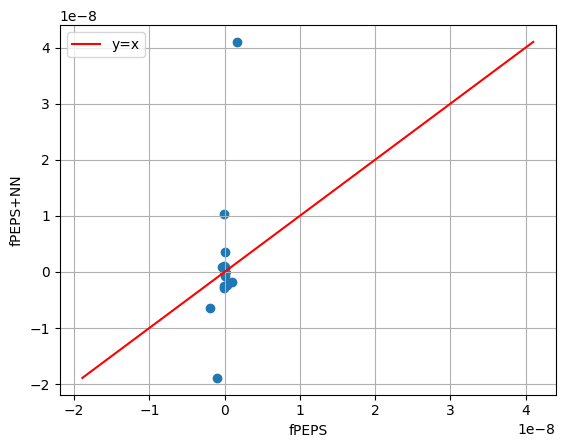

In [11]:
import matplotlib.pyplot as plt
seed = 42
np.random.seed(seed)
random_seed_list = np.random.randint(0, 2**32, size=25)

model1_list = []
model_list = []

for random_seed in random_seed_list:
    random_config = H.hilbert.random_state(jax.random.PRNGKey(random_seed))
    random_config = torch.tensor(random_config, dtype=int)
    model1_list.append(model1(random_config)[0].detach().numpy())
    model_list.append(model(random_config)[0].detach().numpy())

fig, ax = plt.subplots()
ax.scatter(model1_list, model_list)
# plot y=x as reference
x = np.linspace(min(model1_list+model_list), max(model1_list+model_list), 100)
ax.plot(x, x, color='red', label='y=x')
ax.set_xlabel('fPEPS')
ax.set_ylabel('fPEPS+NN')
ax.grid()
plt.legend()
plt.show()

In [56]:
model

fTN_NN_proj_variable_Model(
  (torch_tn_params): ModuleDict(
    (0): ParameterDict(
        ((0, 1, 2)): Parameter containing: [torch.DoubleTensor of size 1x2x1]
        ((0, 2, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2]
        ((1, 0, 2)): Parameter containing: [torch.DoubleTensor of size 2x1x1]
        ((1, 1, 1)): Parameter containing: [torch.DoubleTensor of size 2x2x2]
        ((1, 2, 0)): Parameter containing: [torch.DoubleTensor of size 2x1x1]
        ((2, 0, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2]
        ((2, 1, 0)): Parameter containing: [torch.DoubleTensor of size 1x2x1]
    )
    (1): ParameterDict(
        ((0, -1, -1, 2)): Parameter containing: [torch.DoubleTensor of size 1x1x1x1]
        ((0, -1, 0, 1)): Parameter containing: [torch.DoubleTensor of size 1x1x2x2]
        ((0, -1, 1, 0)): Parameter containing: [torch.DoubleTensor of size 1x1x1x1]
        ((0, 0, -1, 1)): Parameter containing: [torch.DoubleTensor of size 1x2x1x2]
  